In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.io
import os

In [2]:

out_dir =  '/liberatrix/mcintosh_lab/jwang/ModelFitting/Maca/' #'/brunhild/mcintosh_lab/jwang/ModelFitting/Linear_gains/'
batch_size = 82

In [3]:
def sigmoid(x):
    return 1.0/(1+np.exp(-x))
def smooth_normalize(x):
        x[x< 0.000001] =0.000001
    
        return x
def f_diffusion_tr_noise(X, Wo, Theta):
    
    global step_size
    
    def smooth_normalize_ct(x, center):
        return center+ (center-0.001)*np.tanh((x-center)/(center - 0.001))
    def smooth_normalize(x):
        x[x< 0.000001] =0.000001
    
        return x

    def sigmoid(a, b, d, x):
        return (a*x-b)/(1.0000-np.exp(-d*(a*x-b)))
    
    G= 0.001 + smooth_normalize(Theta[4:5])
    W_n = np.reshape(Theta[5:], [batch_size,batch_size])
    W_n = 1+ np.tanh((W_n+W_n.T)/2.0)
    W_n = W_n * Wo
    
    Ws = W_n/np.linalg.norm(W_n)
    gEI= 0.001 + smooth_normalize(Theta[0:1])
    W1= .01 + smooth_normalize(Theta[1:2])
    #gEE= 0.15* (1+np.tanh(Theta[2:3])/5.0)
    gEE= 0.001 + smooth_normalize(Theta[2:3])
    gIE= 0.001+smooth_normalize(Theta[3:4])
    #Tr= 1.
    #step_size = 0.05
    num_para = 0
    dt = step_size
    
    
    L_s = -np.diag(np.sum(Ws, axis= 1)) + Ws
    I0 = 0.3772/1.
    gamma = 0.641/1000.
    gammaI = 1.0/1000.
    #Wplus = .8
    Ie = 0
     #smooth_normalize_ct(_Ji[:,0],1.0)
    aE = 310
    bE = 125
    dE_0 = 0.16
    WE = 1.0 #18.4576#1.0
    
    aI = 615
    bI = 177
    dI_0 = 0.087
    WI = 0.7
    
    tauE = 100.
    tauI = 10.
    
    
    #W1= 0.05
    
    #G = .1
    N=1
    E = X[num_para:num_para+N*ROI_size]#smooth_normalize_ct(X[num_para:num_para+N*ROI_size], 0.5)
    I = X[num_para+N*ROI_size:num_para+2*N*ROI_size]#smooth_normalize_ct(X[num_para+N*ROI_size:num_para+2*N*ROI_size], .5)
    q = X[-N*ROI_size:] #smooth_normalize_ct(X[-N*ROI_size:],1.0)
    v = X[-2*N*ROI_size:-N*ROI_size]#smooth_normalize_ct(X[-2*N*ROI_size:-N*ROI_size],1.)
    f = X[-3*N*ROI_size:-2*N*ROI_size]#smooth_normalize_ct(X[-3*N*ROI_size:-2*N*ROI_size], 1.)
    x = X[-4*N*ROI_size:-3*N*ROI_size]#np.tanh(X[-4*N*ROI_size:-3*N*ROI_size])#smooth_normalize(X[-4*N*ROI_size:-3*N*ROI_size], .5)
    #print(E.shape)
    #subID='AD_016_S_4902.mat'
    
    
    rho=0.34;
    tau_0=0.98;
    #tau_s=0.8;
    #tau_f=0.4;
    alpha =0.32;
    #s=0.5;
    #E = np.tanh(E/200.0)
    #I =np.tanh(I/200.0)
    def fout(v, k):
        return (k*v)**(1.0/alpha)/k
    def Ef(f,k):
        return 1.0-(1.0- rho)**(1.0/f/k)
    
    
    k = 1.
    #x=x/(np.max(np.abs(x))+0.002)
    #print E.shape
    sigma = 1.
    
    epsilon = 1.0 #+ 0.2 *np.tanh(Theta[5:6]) # smooth_normalize(X[5:6], 0.5)
    tau_s = 0.65 #+ 0.2 *np.tanh(Theta[6:7])
    tau_f = 0.41 #+ 0.2 *np.tanh(Theta[7:8])
    for i in range(state_size):
        
        IE = 1*WE*I0 + gEE*E + G*np.dot(L_s, E) -gIE*(I) + Ie
        II = WI*I0 + gEI*E - I 
         
        dE =  E - dt*(E)/tauE \
           +dt*(1.0-E)*gamma*sigmoid(aE, bE, dE_0, IE)\
                +W1*np.sqrt(dt)*np.random.randn(ROI_size)
            
        
        dI =  I - dt*(I)/tauI \
             + dt*gammaI*sigmoid(aI, bI, dI_0, II)+W1*np.sqrt(dt)*np.random.randn(ROI_size)
        
        
        dx = x+dt*(epsilon*(E)/sigma \
                   -1.0/tau_s*x \
               -1.0/tau_f *(k*f-1))
        f_tmp= f+dt*1/k*x
        dv= v+dt*(f/tau_0 -fout(v,k)/tau_0)
        dq= q+ dt*(f*Ef(f,k)/rho/tau_0\
                  -q/v*fout(v,k)/tau_0)
        df = f_tmp
        
        x = np.tanh(dx) #smooth_normalize(dx, 0.5)
        v= 1.0+ np.tanh(dv-1.0)#smooth_normalize_ct(dv, tf.constant(1., dtype=tf.float32), tf.constant(0., dtype=tf.float32), tf.constant(1.0, dtype=tf.float32))
        q=  1.0+ np.tanh(dq-1.0)#smooth_normalize_ct(dq, tf.constant(1., dtype=tf.float32), tf.constant(0., dtype=tf.float32), tf.constant(1.0, dtype=tf.float32))
        f= 1.0+ np.tanh(f_tmp-1.0) 
        E = np.tanh(dE)#1.0 + np.tanh(dE - 1.0) #smooth_normalize_ct(dE, 1.0)#np.tanh(dE/200.0)
        I = np.tanh(dI)#1.0 + np.tanh(dI - 1.0)#smooth_normalize_ct(dI, 1.0)#np.tanh(dI/200.0)
    """return np.concatenate((g1,g2,g12,g21,sigma,epsilon,tau_s,tau_f,\
                           E, I, x, f, v, q))"""
    return np.concatenate((E, I, x, f, v, q))

def h_diffusion_noise(X, Theta):
    def smooth_normalize_ct(x, center):
        return center+ (center-0.001)*np.tanh((x-center)/(center - 0.001))
    def smooth_normalize(x):
        x[x< 0.000001] =0.000001
    
        return x

    def sigmoid(a, b, d, x):
        return (a*x-b)/(1.0000-np.exp(-d*(a*x-b)))
    
    W2= 0.02 #Theta[3:4]#0.02 + smooth_normalize(Theta[3:4])
    E0=0.34
    rho=0.34
    k1 = 7*E0
    k2 = 2.
    k3 = 2*E0-0.2
    #w= Theta[3:4]
    #W2 = 0.01
    V = 0.02 #1.0 + smooth_normalize(Theta[9:10])
    #V= 30.0
    q = smooth_normalize_ct(X[-ROI_size:],1.0)
    v = smooth_normalize_ct(X[-2*ROI_size:-ROI_size],1.0)
    k= 1.
    #v = a+ a*np.tanh((v-a)/a)/1.1
    y= k1*(1-k*q)+k2*(1-q/v)+k3*(1-k*v)
    #q = a+ a*np.tanh((q-a)/a)/1.1
    return 100.0/E0*V*(y)#+W2*np.random.randn(ROI_size)

In [9]:
Tr= 2.5
num_epochs =60*1
echo_step = 0
num_data = TS.shape[0]
truncated_backprop_length = 15
total_series_length = num_data -echo_step #50000

step_size = 0.05
state_size = 6 #np.int(6* Tr/step_size)

num_classes = 1
batch_size = 82
num_batches = total_series_length//truncated_backprop_length

In [11]:
tf.reset_default_graph()
    
    
L_new = tf.placeholder(tf.float32, [batch_size, batch_size])
batchX_placeholder = tf.placeholder(tf.float32, [batch_size, 1+truncated_backprop_length+2*truncated_backprop_length*np.int(Tr/step_size)])
batchY_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length])

init_state = tf.placeholder(tf.float32, [batch_size, state_size])



def fout(v, alpha):
    return tf.pow(v,1./alpha)
def Ef(f):
    rho = 0.34
    return tf.constant(1., dtype=tf.float32)-tf.pow(tf.constant(1.-rho, dtype=tf.float32), tf.reciprocal(f))
def h_tf(a, b, d, x):
    return( 0.00001+tf.abs(a*x-b))/(0.00001*d+tf.abs(1.0000 -tf.exp(-d*(a*x-b))))






sigma = tf.constant(1.0, dtype=tf.float32) 
epsilon = tf.constant(1.0, dtype=tf.float32)# + 0.3 *np.tanh(X[5:6]) # smooth_normalize(X[5:6], 0.5)
tau_s = tf.constant(0.65, dtype=tf.float32)# + 0.2 *np.tanh(X[6:7])
tau_f = tf.constant(0.41, dtype=tf.float32)# + 0.3 *np.tanh(X[7:8])

I0=tf.constant(0.3772, dtype=tf.float32)
gamma = tf.constant(0.641/1000.0, dtype=tf.float32)
gammaI = tf.constant(1/1000.0, dtype=tf.float32)

Ie = tf.constant(0.0, dtype=tf.float32)

aE=tf.constant(310, dtype=tf.float32)
bE = tf.constant(125, dtype=tf.float32)
dE =tf.constant(0.16, dtype=tf.float32)
WE= tf.constant(1, dtype=tf.float32)
tauE= tf.constant(100, dtype=tf.float32)

aI=tf.constant(615, dtype=tf.float32)
bI = tf.constant(177, dtype=tf.float32)
dI =tf.constant(0.087, dtype=tf.float32)
WI= tf.constant(0.7, dtype=tf.float32)
tauI= tf.constant(10, dtype=tf.float32)

rho=tf.constant(0.34, dtype=tf.float32)
E0=tf.constant(0.34, dtype=tf.float32)
k1 = tf.constant(7*0.34, dtype=tf.float32)
k2 =tf.constant( 2, dtype=tf.float32)
k3 = tf.constant(2*0.34-0.2, dtype=tf.float32)
   
V = tf.constant(0.02, dtype=tf.float32)
rho= tf.constant(0.34, dtype=tf.float32)
tau_0= tf.constant(0.98, dtype=tf.float32) 
    #tau_s=0.8;
    #tau_f=0.4;
alpha =tf.constant(0.32, dtype=tf.float32)

dt=tf.constant(step_size, dtype=tf.float32)
   
E_fr= tf.constant(np.zeros((batch_size,1)), dtype=tf.float32)

#gi0 = 1.* np.zeros((batch_size,1))
Ws0 = np.zeros((batch_size,batch_size))+0.05
g0 = 80.
   
W1 = tf.Variable(0.02, dtype=tf.float32)
gEE =tf.Variable(0.15, dtype=tf.float32)
G = tf.Variable(g0, dtype=tf.float32)
#Gi = tf.Variable(gi0, dtype=tf.float32)
Ws = tf.Variable(Ws0, dtype=tf.float32)
gEI = tf.Variable(0.15, dtype=tf.float32)

gIE = tf.Variable(1.0, dtype=tf.float32)   
    

# Unpack columns

inputs_series = tf.unstack(batchX_placeholder, axis=1)
labels_series = tf.unstack(batchY_placeholder, axis=1)

W_n= 1+tf.tanh((Ws+tf.transpose(Ws))/2.0)
W_n = W_n * L_new

W_s =W_n/tf.norm(W_n)
L= -tf.diag(tf.reduce_sum(W_s, axis=1)) + W_s

# Forward pass
current_state = init_state
#current_state = _current_state
states_series = []
EI_series = []
logits_series = []
noise2 = inputs_series[-truncated_backprop_length-1:-1]
noise_c = inputs_series[-1]


for j, label_tmp in enumerate(labels_series):
    #current_input = tf.reshape(current_input, [batch_size, 1])
    #input_and_state_concatenated = tf.concat([current_input, current_state],1)  # Increasing number of columns
    
    
  
    E=current_state[:,0:1]
    I=current_state[:,1:2]
    x=current_state[:,2:3]
    f=current_state[:,3:4]
    v=current_state[:,4:5]
    q=current_state[:,5:6]
    
    G_p = 0.001+tf.nn.relu(G)
    #G_p = 5000./0.641/0.459 +tf.nn.relu(G)
    gIE_p = 0.001+ tf.nn.relu(gIE) #smooth_normalize_ct(Ji, tf.constant(1.0, dtype=tf.float32), tf.constant(0.0, dtype=tf.float32), tf.constant(1.0, dtype=tf.float32))
    
    gEI_p =0.001+tf.nn.relu(gEI)
    gEE_p =0.001+ tf.nn.relu(gEE)
    
    
    W1_p = .01 + tf.nn.relu(W1)
    #W2_p = 0.01 + tf.nn.relu(W2)
    #W = (Gi_p*L_new)/tf.norm(Gi_p*L_new)
    #L = -tf.diag(tf.reduce_sum(W, axis=1)) + W
    for i in range(np.int(Tr/step_size)):
        noise = tf.reshape(inputs_series[j*np.int(Tr/step_size)+i],[batch_size, 1] )
        noise1 = tf.reshape(inputs_series[truncated_backprop_length*np.int(Tr/step_size)\
                                          +j*np.int(Tr/step_size)+i],[batch_size, 1] )
        IE = tf.nn.relu(WE*I0 + gEE_p*E + G_p*tf.matmul(L, E) -gIE_p*(I) + Ie)
        II = tf.nn.relu(WI*I0 + gEI_p*E - I)
        
        #IE = 125/310.0 -0.026 +0.006*tf.tanh(IE/100. - 125/310.0 + 0.026) 
        #(3.0631+0.4869*tf.tanh(h_tf(aE, bE, dE, IE)-3.0631)) 
        E_new =E  -dt*(E)/tauE \
                    + dt*(1.0 -E)*gamma*h_tf(aE, bE, dE, IE) \
                    +W1_p*tf.sqrt(dt)*noise
        I_new =I - dt*(I)/tauI \
                   + dt*gammaI*h_tf(aI, bI, dI, II) +W1_p*tf.sqrt(dt)*noise1
    
    
        dx = x+dt*(epsilon*E/sigma-1.0/tau_s*x  -1.0/tau_f*(f-1.0))
        f_tmp= f+dt*x 
        dv= v+dt*(f/tau_0 -fout(v, alpha)/tau_0) 
        dq=q+ dt*(tf.multiply(f,Ef(f))/rho/tau_0-tf.multiply(tf.divide(q,v) ,fout(v, alpha)) /tau_0)
        v= 1.0+ tf.tanh(dv-1.0)#smooth_normalize_ct(dv, tf.constant(1., dtype=tf.float32), tf.constant(0., dtype=tf.float32), tf.constant(1.0, dtype=tf.float32))
        q=  1.0+ tf.tanh(dq-1.0)#smooth_normalize_ct(dq, tf.constant(1., dtype=tf.float32), tf.constant(0., dtype=tf.float32), tf.constant(1.0, dtype=tf.float32))
        f= 1.0+ tf.tanh(f_tmp-1.0) #smooth_normalize_ct(f_tmp, tf.constant(1., dtype=tf.float32), tf.constant(0., dtype=tf.float32), tf.constant(1.0, dtype=tf.float32))
        x= tf.tanh(dx)
        E= tf.tanh(E_new) #smooth_normalize_ct(E_new, tf.constant(1., dtype=tf.float32), tf.constant(0., dtype=tf.float32), tf.constant(1.0, dtype=tf.float32))
        I= tf.tanh(I_new) #smooth_normalize_ct(I_new, tf.constant(1., dtype=tf.float32), tf.constant(0., dtype=tf.float32), tf.constant(1.0, dtype=tf.float32))
        EI_state = tf.concat([E, I],1) 
        EI_series.append(EI_state)
        #E_fr = sigmoid_tf(aE, bE, dE, IE)
    next_state = tf.concat([E, I, x, f, v, q],1)  # Broadcasted addition
    #IE = WE*I0 + Wplus_p*Jnmda_p*E + G_p*Jnmda_p*tf.matmul(W, E) -tf.multiply(Ji_p,I) + Ie
    #E_fr = h_tf(aE, bE, dE, IE)
    states_series.append(next_state)
    #inhi_series.append(E_fr)
    current_state = next_state 
#current_state = states_series[0]
print(states_series[0].shape)
print(inputs_series[0].shape)
print(len(inputs_series))
#logits_series = [tf.reshape(tf.matmul(W2, tf.reshape(tf.tanh(state), [batch_size*state_size, 1])) + b2, [batch_size,]) for state in states_series]#Broadcasted addition

logits_series = [100.0/E0*V*(k1*(tf.constant(1., dtype=tf.float32)-state[:, 5])\
                 +k2*(tf.constant(1., dtype=tf.float32)-tf.divide(state[:, 5],state[:, 4]))\
                 +k3*(tf.constant(1., dtype=tf.float32)-state[:, 4]))\
                 +0.02*noise   for state, noise in zip(states_series, noise2)]
print(logits_series[0].shape)
print(labels_series[0].shape)

predictions_series = logits_series

labels_series_tf = tf.stack(labels_series,axis=1)
logits_series_tf = tf.stack(logits_series,axis=1)
#labels_series_tf = labels_series[0]
#logits_series_tf = states_series[0]
labels_series_tf_n = labels_series_tf - tf.matmul(tf.reshape(tf.reduce_mean(labels_series_tf, 1), [batch_size,1]),\
                            tf.constant(np.ones((1,truncated_backprop_length)), dtype=tf.float32))
logits_series_tf_n = logits_series_tf - tf.matmul(tf.reshape(tf.reduce_mean(logits_series_tf, 1), [batch_size,1]),\
                            tf.constant(np.ones((1,truncated_backprop_length)), dtype=tf.float32))


cov_sim =tf.matmul(logits_series_tf_n, tf.transpose(logits_series_tf_n))
cov_def= tf.matmul(labels_series_tf_n, tf.transpose(labels_series_tf_n))


FC_sim_T = tf.matmul(tf.matmul(tf.diag(tf.reciprocal(tf.sqrt(tf.diag_part(cov_sim)))), cov_sim), \
                     tf.diag(tf.reciprocal(tf.sqrt(tf.diag_part(cov_sim)))))
FC_T = tf.matmul(tf.matmul(tf.diag(tf.reciprocal(tf.sqrt(tf.diag_part(cov_def)))), cov_def), \
                 tf.diag(tf.reciprocal(tf.sqrt(tf.diag_part(cov_def))))) 
#FC_T= tf.constant(FC, dtype=tf.float32)

ones_tri=tf.matrix_band_part(tf.ones_like(FC_T)-tf.diag(tf.ones((batch_size,))), 0, -1)
zeros = tf.zeros_like(FC_T) # create a tensor all ones
mask = tf.greater(ones_tri, zeros) # boolean tensor, mask[i] = True iff x[i] > 1
FC_tri_v = tf.boolean_mask(FC_T, mask)

FC_v = FC_tri_v - tf.reduce_mean(FC_tri_v)*tf.ones_like(FC_tri_v)


FC_sim_tri_v = tf.boolean_mask(FC_sim_T, mask)
FC_sim_v = FC_sim_tri_v - tf.reduce_mean(FC_sim_tri_v)*tf.ones_like(FC_sim_tri_v)

corr_FC =tf.reduce_sum(tf.multiply(FC_v,FC_sim_v))\
                  /tf.sqrt(tf.reduce_sum(tf.multiply(FC_v,FC_v)))\
                /tf.sqrt(tf.reduce_sum(tf.multiply(FC_sim_v,FC_sim_v)))
        
losses_corr = tf.square(1- corr_FC)
losses = tf.sqrt(tf.reduce_mean(tf.multiply(FC_sim_v-FC_v, FC_sim_v-FC_v)))
#losses = tf.sqrt(tf.reduce_mean(tf.multiply(cov_sim-cov_def, cov_sim-cov_def)))

    
total_loss = losses_corr #+ 0.05*W1**2
      

#losses = [tf.losses.mean_squared_error(labels, logits) for logits, labels in zip(logits_series,labels_series)]

#total_loss = tf.reduce_mean(losses) #+ 0.01*(g1**2 + 2*g12**2 + g21**2)


opt_func = tf.train.AdamOptimizer(.01)




train_step=opt_func.minimize(total_loss)
#train_step = tf.train.GradientDescentOptimizer(.05).minimize(total_loss)
#train_step = tf.train.MomentumOptimizer(learning_rate=0.08, momentum=0.9).minimize(total_loss)
#train_step = tf.train.AdamOptimizer(0.02).minimize(total_loss)


(82, 6)
(82,)
1516
(82,)
(82,)


In [ ]:
def plot(batch_idx,  W_s, y_array,  E_array, I_array,params_list, loss_list):
       
    plt.subplot(3, 3, 1)
    plt.cla()
    plt.plot(loss_list)
    
    plt.subplot(3, 3, 2)
    plt.cla()
    plt.plot(params_list[:,0:1])
    
    plt.subplot(3, 3, 3)
    plt.cla()
    plt.plot(E_array.mean(0), I_array.mean(0))
    plt.subplot(3, 3, 4)
    plt.cla()
    plt.plot(params_list[:,2])
    plt.subplot(3, 3, 5)
    plt.cla()
    plt.plot(params_list[:,3])
    plt.subplot(3, 3, 6)
    plt.cla()
    plt.plot(params_list[:,4])
    
    
    plt.subplot(3, 3, 7)
    plt.cla()
    plt.plot(params_list[:,5:])
    
    
    plt.subplot(3, 3, 8)
    plt.cla()
    plt.imshow(W_s)
    
    
    plt.subplot(3, 3, 9)
    plt.cla()
    plt.plot(y_array.T)

    
        
    plt.draw()
    plt.pause(0.0001)

In [12]:
def model_run(subID,L_s, TS):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        plt.ion()
        plt.figure()
        plt.show()
        loss_list = []
        params_list = []
        
        
       
        Ws_old = list(np.zeros((83,83)).ravel())
        gEI_old = .15
        W1_old = 0.5
        gEE_old = .15
        gIE_old = 1.
        G_old = 100.
   
        loss_array_old = np.zeros((truncated_backprop_length,))
    
    
        for epoch_idx in range(num_epochs):
        
            TS_dmean =(TS.T -TS.T.mean(axis= 0)).T
            y_in= TS.T[:,echo_step:num_data]/np.max(TS)
            if len(loss_list) == 0 or loss_list[len(loss_list)-1]> 0.002:
            
                y_array =np.zeros((batch_size,num_batches*truncated_backprop_length))
                E_array =np.zeros((batch_size,num_batches*truncated_backprop_length*np.int(Tr/step_size)))
                I_array =np.zeros((batch_size,num_batches*truncated_backprop_length*np.int(Tr/step_size)))
                
                initi_con = .45*(np.random.uniform(0,1,[batch_size, state_size])+np.array([[0, 0, 0,.5,.5,.5]]))
                #initi_con[:,0:2]= 0
                _current_state = initi_con
            
            
                params_old = np.array([gEI_old,  W1_old,  gEE_old, gIE_old, G_old] + Ws_old)
                #print("New data, epoch", epoch_idx)
                loss_array = np.zeros((num_batches,))
                for batch_idx in range(num_batches):
                
                    
                    #for batch_idx in range(209-truncated_backprop_length):
                    start_idx = batch_idx * truncated_backprop_length
                    #start_idx = batch_idx 
                    end_idx = start_idx + truncated_backprop_length

                    batchX = np.random.randn(batch_size, 1+truncated_backprop_length+2*truncated_backprop_length*np.int(Tr/step_size))
                    batchY = y_in[:,start_idx:end_idx]

                    _W_s, _Ws, _G, _gEI, _gIE, _W1, _gEE, _total_loss, _train_step, _current_state,\
                               _logits_series, _states_series = sess.run(
                    [W_s, Ws, G, gEI, gIE, W1, gEE, total_loss, train_step, current_state, logits_series, EI_series],
                    feed_dict={
                        batchX_placeholder:batchX,
                        batchY_placeholder:batchY,
                        init_state:_current_state,
                        L_new:L_s
                        })

                    loss_list.append(_total_loss)
                    params_new = np.array([_gEI, _W1, _gEE, _gIE, _G] +list(_Ws.ravel()))#1/(1+np.exp(-_W1))
                    params_list.append(params_new)
                    
                    
                    loss_array[batch_idx] = _total_loss
                
                    for i in range(truncated_backprop_length):
                        start_idx = batch_idx * truncated_backprop_length
                
                        y_array[:, start_idx+i] = _logits_series[i]
                        for j in range(np.int(Tr/step_size)):
                            E_array[:, (start_idx+i)*np.int(Tr/step_size)+j] = _states_series[i*np.int(Tr/step_size)+j][:,0]
                            I_array[:, (start_idx+i)*np.int(Tr/step_size)+j] = _states_series[i*np.int(Tr/step_size)+j][:,1]
                   
                
                
                    #print("Step",batch_idx, "Loss", _total_loss)
                
                
        
       
            
    plot(batch_idx, _W_s, y_array, E_array, I_array, np.array(params_list), loss_list)        
    plt.ioff()
    plt.show()
    #print(Ji_list)
    np.savetxt(out_dir+'Maca_'+subID+'paramsList_test.txt', np.array(params_list))
    #np.savetxt(Out_path+'PPMI_'+subID+'Ji.txt', np.array(Ji_list))
    np.savetxt(out_dir+'Maca_'+subID+'sim_fitting_bold_test.txt', y_array.T)
    np.savetxt(out_dir+'Maca_'+subID+'sim_fitting_E_test.txt', E_array.T)
    np.savetxt(out_dir+'Maca_'+subID+'sim_fitting_I_test.txt', I_array.T)
    #y_dmean =(y_array.T -y_array.T.mean(axis= 0)).T
    FC_sim = np.corrcoef(y_array[:,10:])
    
    FC = np.corrcoef(TS.T)
    corr_simfit= np.corrcoef(FC[np.tril_indices(batch_size,-1)], FC_sim[np.tril_indices(batch_size,-1)])[0,1]
    print(corr_simfit)
    Maca_par_corr[subID].append(corr_simfit)
    fig, ax = plt.subplots(1,3, figsize=(20,4))
    ax[0].plot(TS)
    img1 =ax[1].imshow(FC_sim -np.diag(np.diag(FC_sim)), cmap='bwr')
    plt.colorbar(img1, ax=ax[1], fraction=0.046, pad=0.04)
    img2 =ax[2].imshow(FC, cmap='bwr')
    plt.colorbar(img2, ax=ax[2], fraction=0.046, pad=0.04)
    plt.show()


In [ ]:
data['rsfMRI_timeseries'].shape

0 Maca_0_0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


<Figure size 432x288 with 0 Axes>

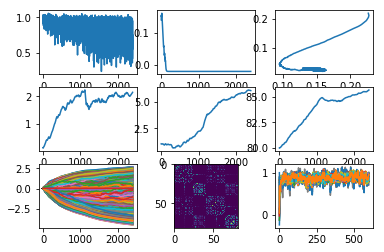

0.6262125187809657


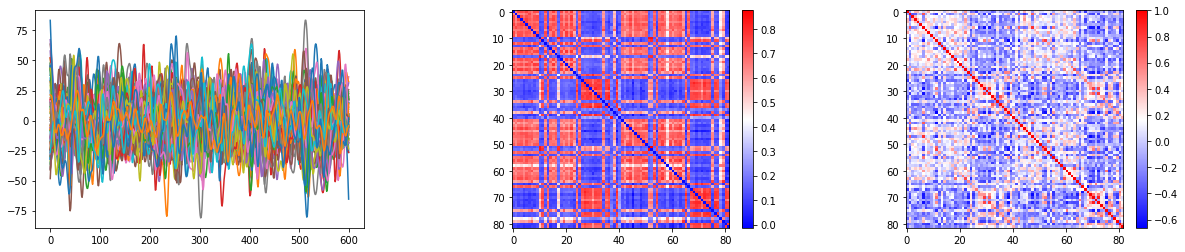

0.5958311922905836


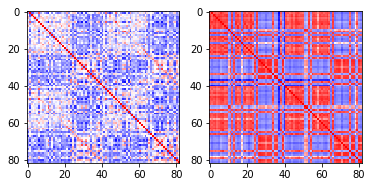

0 Maca_0_1
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


<Figure size 432x288 with 0 Axes>

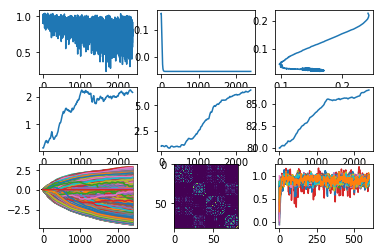

0.6345200659470731


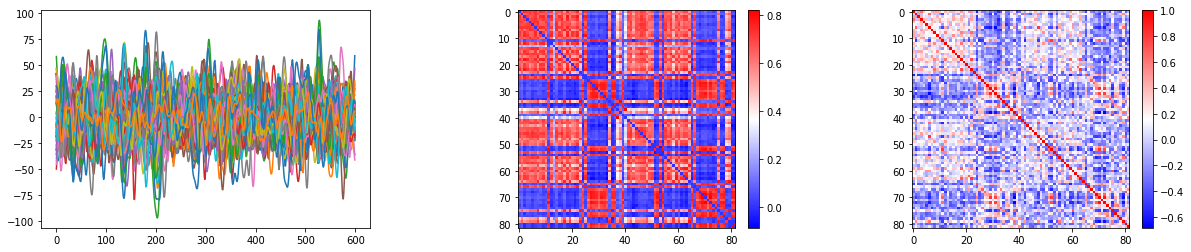

0.6253633196445824


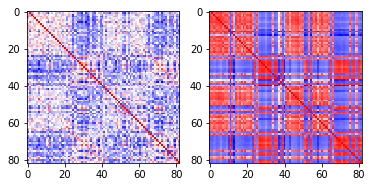

0 Maca_0_2
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


<Figure size 432x288 with 0 Axes>

In [ ]:
batch_size = 82
Maca_par_corr= {}
ROI_size = 82

file_name = '/liberatrix/mcintosh_lab/kshen/TVBmacaque/forZhengmacaque_SC_timeseries.mat'

data = scipy.io.loadmat(file_name)

for i in range(data['SCMats'].shape[0]):
    for j in range(4):
        sub ="Maca_"+str(i)+'_'+str(j)
        print(i, sub)
    



    
    
        Maca_par_corr[sub] = []
        SC= data['SCMats'][i,:,:]
        SC = SC- np.diag(np.diag(SC))
        SC = (SC+SC.T)*0.5
        TS = data['rsfMRI_timeseries'][i,j,:,:]
        
        TS_dmean =(TS.T -TS.T.mean(axis= 0)).T
        
        Wo = np.log1p(SC)/np.linalg.norm(np.log1p(SC))
        print(np.diag(Wo))
        #L_s = (-np.diag(np.sum(W0, axis= 1)) + W0).astype(np.float32)
            
            
        num_data = TS.shape[0]

        total_series_length = num_data -echo_step #50000


        num_batches = total_series_length//truncated_backprop_length
            
        model_run(sub,Wo, TS_dmean)
    
        X0 = np.ones((6*batch_size,))/10.
        params = np.loadtxt(out_dir+'Maca_'+sub+'paramsList_test.txt')
        Theta = params[-10:,:].mean(axis = 0)

        tys=[]
        Es=[]
        Is=[]
        ROI_size= batch_size
        for j in range(4000):
            X = f_diffusion_tr_noise(X0,Wo, Theta)
        
            X0 = X
    
            tys.append(h_diffusion_noise(X0, Theta))
            E = X[:ROI_size]#smooth_normalize_ct(X[num_para:num_para+N*ROI_size], 0.5)
            I = X[ROI_size:2*ROI_size]
            Es.append(E)
            Is.append(I)
        
        tys=np.array(tys)
        #tys_dmean =(tys.T -tys.T.mean(axis= 0)).T
        FC_sim = np.corrcoef(tys[20:,:].T)
        FC=np.corrcoef(TS_dmean.T)
        np.savetxt(out_dir+'Maca_'+sub+'sim_bold_test.txt', np.array(tys))
        np.savetxt(out_dir+'Maca_'+sub+'sim_E_test.txt', np.array(Es))
        np.savetxt(out_dir+'Maca_'+sub+'sim_I_test.txt', np.array(Is))
        print(np.corrcoef(FC[np.tril_indices(batch_size,-1)], FC_sim[np.tril_indices(batch_size,-1)])[0,1])
        Maca_par_corr[sub].append(np.corrcoef(FC[np.tril_indices(batch_size,-1)], FC_sim[np.tril_indices(batch_size,-1)])[0,1])
            
    
        Maca_par_corr[sub].append(.001+ smooth_normalize(Theta[0:1])[0])
        Maca_par_corr[sub].append(.001+ smooth_normalize(Theta[1:2])[0])
        Maca_par_corr[sub].append(.001+ smooth_normalize(Theta[2:3])[0])
        Maca_par_corr[sub].append(.01+ smooth_normalize(Theta[3:4])[0])
        Maca_par_corr[sub].append(.001+ smooth_normalize(Theta[4:5])[0])
        W_n_a = np.reshape(Theta[5:], [batch_size,batch_size])
        W_n_a = 1+ np.tanh((W_n_a+W_n_a.T)/2.0)
        W_n_a = W_n_a * Wo
    
        Ws_a = W_n_a/np.linalg.norm(W_n_a)
        Maca_par_corr[sub].extend(list(Ws_a.ravel()))
        
            
        fig, ax = plt.subplots(1,2)
        ax[0].imshow(FC, cmap='bwr')
        ax[1].imshow(FC_sim, cmap='bwr')
        plt.show()


 

    


In [ ]:
HCP_par_corr_new={}
for sub in HCP_par_corr:
    HCP_par_corr_new['sub'+sub] = HCP_par_corr[sub]

In [16]:
out_dir

'/liberatrix/mcintosh_lab/jwang/ModelFitting/simData_Fr/DecoAdam/'

In [15]:
TS

array([[  9.98702447,  61.10299601,   1.80622926, ...,  15.52993556,
        125.4898203 ,  63.46710174],
       [  9.90892734,  52.11192979,   1.01337936, ...,  14.04404195,
        107.9081467 ,  57.73419514],
       [  9.58492906,  42.89118576,   1.10676515, ...,  12.58644341,
         90.30162645,  51.15337783],
       ...,
       [ -7.57286646,  -5.67207275,  -2.16416954, ..., -10.39795116,
        -13.16933504, -11.20593405],
       [ -7.79354084,  -1.58532879,  -6.14526841, ...,  -9.28526535,
         -6.77690046,  -9.00756655],
       [ -7.92735044,   2.82844159,  -9.56832549, ...,  -7.43349076,
         -0.46765745,  -7.07963779]])